<font color='green'>

## Import Libraries

</font>

In [1]:
import time
import numpy as np
from plotly import graph_objects as go
import matplotlib.pyplot as plt

from loguru import logger

import ray
from ray import tune

import torch
from torch import optim
from torch import nn

from pathlib import Path
import gin

import warnings
warnings.simplefilter("ignore", UserWarning)

%matplotlib inline
plt.style.use('dark_background')
# import plotly.io as pio
# pio.renderers.default = 'plotly_mimetype+notebook'

import visualize
start = time.time()

<font color='green'>

## Training and validation function

Similar to the prvious lesson, we will include the the training and validation functions to perform the Bayes search on the parameters. 

</font>

In [2]:
def train_fn(model, trainstreamer, lossfn, optimizer, steps):
    model.train()
    train_loss: float = 0.0
    for _ in range(steps):
        x, y = next(trainstreamer)
        optimizer.zero_grad()
        yhat = model(x)
        loss = lossfn(yhat, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss

def validate(model, validstreamer, lossfn, metric, steps):
    model.eval()
    valid_loss: float = 0.0
    acc: float = 0.0
    with torch.no_grad():
        for _ in range(steps):
            x, y = next(validstreamer)
            yhat = model(x)
            loss = lossfn(yhat, y)
            valid_loss += loss.item()
            acc += metric(y, yhat)
    acc /= steps
    return valid_loss, acc

### Data
You can pick the gestures dataset, which is pretty fast en easy to reach high accuracy on.
You could also pick the flowers if you want to test images, or the ants/bees, or any other datasets from `mads_datasets` or even another set you like from [torchvision](https://pytorch.org/vision/0.8/datasets.html) or [torchtext](https://pytorch.org/text/stable/datasets.html#imdb).

Keep in mind that your hardware will limit what you can do with the images; if you have a GPU or use a free GPU from google colab, it's much faster to run tests.

<font color='green'>

**Tasks performed:**
- For this task we use the `GESTURES` dataset for GRU model and `FASHION` dataset for RESNET model from the `mads_datasets`.
- `GESTURES` is a time-series data with x, y and z accelerometer data for 20 gestures.
- `FASHION` is a image data with 60k images sized 28x28 pixels for 10 classes.
- The `get_data` funciton is implemented with MLtrainer, similar to our previous lessons to get the data.
- The `get_data` function will handle the condition of whether we require time-series data or image data through an if-statement.
- The image data requires few extra steps, like data augmentation. So, added the augmentation process for the image dataset in the next code-section.

</font>


In [3]:
from torchvision import transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

class AugmentPreprocessor():
    def __init__(self, transform):
        self.transform = transform
    def __call__(self, batch: list[tuple]) -> tuple[torch.Tensor, torch.Tensor]:
        X, y = zip(*batch)
        X = [self.transform(x) for x in X]
        return torch.stack(X), torch.stack(y)

In [4]:
def get_data(tune_dir, dataname):
    from filelock import FileLock
    from mads_datasets import DatasetFactoryProvider, DatasetType
    from mltrainer.preprocessors import PaddedPreprocessor
    from mads_datasets import DatasetFactoryProvider, DatasetType
    with FileLock(tune_dir / ".lock"):
        # we lock the datadir to avoid parallel instances trying to
        # access the datadir
        if dataname == 'GRU':
            preprocessor = PaddedPreprocessor()
            datasetfactory = DatasetFactoryProvider.create_factory(DatasetType.GESTURES)
            streamers = datasetfactory.create_datastreamer(
                batchsize=32, preprocessor=preprocessor
            )
            train = streamers["train"]
            valid = streamers["valid"]

        elif dataname == 'RESNET':
            # Loading image data
            datasetfactory = DatasetFactoryProvider.create_factory(DatasetType.FLOWERS)
            streamers = datasetfactory.create_datastreamer(batchsize=32)
            trainprocessor= AugmentPreprocessor(data_transforms["train"])
            validprocessor = AugmentPreprocessor(data_transforms["val"])
            train = streamers["train"]
            valid = streamers["valid"]
            train.preprocessor = trainprocessor
            valid.preprocessor = validprocessor
        
    return train, valid

## Create a model
We have worked with a few types of layers:
- linear
- conv2d
- RNNs (GRU, LSTM)
- dropout, batchnorm

and we have also seen architectures like resnet (skiplayers), squeeze-excite and googlenet (inception).
It's up to you to create a configurable model now that can be hypertuned.

<font color='green'>

## Creating model for the parameter search
- For the purpose of the completeness of the excercise. I will be using GRU and a RESNET model to perform the parameter search.
- Both the models will be used for parameter search. 
- I have tried to make these models configurable through `gin-config`, but it is not working with `tune` library.
- It is also not necessary to make a configurable model, as we will be searching for parameters. So, defining one parameter through config file, and getting overridden by parameter search algorithm.

</font>

<font color='green'>

##### **Defining GRUmodel.**

- The `GRU` model is defined in the following code section.
- It will take config dictonary as an argument and built a GRU model.
- For this model, we will search for `hidden_size`, `num_layers`, and `dropout` variables.

</font>

In [5]:
class GRUmodel(nn.Module):
    def __init__(
        self,
        config: dict,
    ) -> None:
        super().__init__()
        self.rnn = nn.GRU(
            input_size=config["input_size"],
            hidden_size=int(config["hidden_size"]),
            dropout=config["dropout"],
            batch_first=True,
            num_layers=int(config["num_layers"]),
        )
        self.linear = nn.Linear(int(config["hidden_size"]), config["output_size"])

    def forward(self, x):
        x, _ = self.rnn(x)
        last_step = x[:, -1, :]
        yhat = self.linear(last_step)
        return yhat

<font color='green'>

##### **Defining RESNET model.**

- The `Resnet` model is defined in the following code section.
- First, we import the trained weights from the torch repository.
- Then, we freeze the trained model weights to make it converge faster.
- Lastly, we define a linear layer to make the last classification.
- For this model, we will search for `fc_layer` and `dropout` variables.

</font>


In [25]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights

class ResNetModel(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)  # Load pretrained ResNet18

        for name, param in self.resnet.named_parameters():
            param.requires_grad = False
        # Modify the final fully connected layer
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
                            nn.Linear(in_features, int(config['fc_layer'])), 
                            nn.ReLU(), 
                            nn.Dropout(config['dropout']), 
                            nn.Linear(int(config['fc_layer']), int(config['output_size']))
                        )

    def forward(self, x):
        return self.resnet(x)


<font color='green'>

We will now define a function to used to serach the best parameters for our method. This function will first loads the data with a lock then creates the model, after that it trains and validates the model and finally reports the results to ray.
</font>


In [26]:
tune_dir = Path("models/ray/").resolve()
MAX_EPOCHS = 5
N_EXPERIMENTS = 18

In [27]:
def tune_model(config: dict):
    from mltrainer.metrics import Accuracy

    # load data
    train, valid = get_data(config["tune_dir"], config["model_name"])
    trainsteps = len(train)
    validsteps = len(valid)
    trainstreamer = train.stream()
    validstreamer = valid.stream()

    # create model with config
    if config["model_name"] == "GRU":
        model = GRUmodel(config)
    elif config["model_name"] == "RESNET":
        model = ResNetModel(config)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.CrossEntropyLoss()
    metric = Accuracy()

    for _ in range(config["epochs"]):
        # train and validate
        train_loss = train_fn(model, trainstreamer, loss_fn, optimizer, trainsteps)
        valid_loss, accuracy = validate(model, validstreamer, loss_fn, metric, validsteps)

        # report to ray
        ray.train.report({
            "valid_loss": valid_loss / validsteps,
            "train_loss": train_loss / trainsteps,
            "accuracy" : accuracy.cpu().detach().numpy(), # edit to also work with cuda ('ray' does not work with Tensor object)
            })


In [28]:
def plot_contour(df, x, y, z, start=0.90, end=1.0, size=0.01):
    fig = go.Figure()

    fig.add_trace(
        go.Contour(
            z=df[z],
            x=df[x],
            y=df[y],
            contours=dict(
                coloring='heatmap',
                showlabels=True,  # show labels on contours
                start=start,       # start of the contour range
                end=end,          # end of the contour range
                size=size,
            ),
            colorscale="plasma",
            colorbar=dict(
                title='Accuracy'
            )
        )
    )

    fig.add_trace(
        go.Scatter(
            x=df[x],
            y=df[y],
            mode='markers',
            marker=dict(
                color='black',
                size=8,
                symbol='circle'
            ),
            customdata=df['accuracy'],  # Pass accuracy values for hover text
            hovertemplate=(
                'Hidden Size: %{x}<br>'
                'Dropout: %{y:.2f}<br>'
                'Accuracy: %{customdata:.4f}<extra></extra>'
            ),
            name='Data Points'
        )
    )

    fig.update_layout(
        title="Contour Plot",
        xaxis_title="Hidden Size",
        yaxis_title="Dropout",
        xaxis=dict(showgrid=False),  # Remove x-axis grid lines
        yaxis=dict(showgrid=False),
        plot_bgcolor='white',        # Set background color to white
        paper_bgcolor='white'
    )

    fig.show()

<font color='green'>

## Bayes search 

We will perform the Bayes search on the `dropout` and `hidden_size` for the provided model. 

As the dropout directly dependent on the number of hidden neurons in the model, so it will be a intresting to visualize the relations of these two hyper-parameters. Bayes search takes the continous values of the parameters to search, hence the dropout will work as it is, whereas the hidden_size values are casted within model function to make it work.

- The value of dropout range from 0 to 1.0 (where 1.0 to drops all the neurons from learning)
- Whereas, the value of hidden_size ranges from 16 to 512. In practical, the value of hidden_size should in a multiple of 2 ranging from 16 to 512, but in Bayes search we are complied to use the 'uniform' search between those ranging without explicitly mentioning the factor 2 value.

</font>


<font color='green'>
To make sure that ray uses less RAM. Currently, it is set to use 1GB memory.
</font>

In [ ]:
ray.init(object_store_memory=10**9)

In [11]:
from ray.tune.search.bayesopt import BayesOptSearch

bayesopt = BayesOptSearch(random_search_steps=5)


config = {
    "input_size": 3,
    "output_size": 20,
    "dropout": tune.uniform(0, 1.0),
    "epochs": MAX_EPOCHS,
    "hidden_size": tune.uniform(16, 512),
    "num_layers": tune.uniform(1, 8),
    "tune_dir": tune_dir,
    "model_name": "GRU",
}

tic = time.time()

analysis_bayes = tune.run(
    tune_model,
    config=config,
    metric="valid_loss",
    mode="min",
    storage_path=str(tune_dir),         # edit from 'local_dir' to 'storrage_path'
    num_samples=N_EXPERIMENTS,
    stop={"training_iteration": MAX_EPOCHS},
    search_alg=bayesopt,
    verbose=1,
    max_concurrent_trials=8,    # edit To reduce the OEM error
)

timer = time.time() - tic

best_bayes = analysis_bayes.get_best_config()
best_bayes["accuracy"] = analysis_bayes.best_result["accuracy"]

(raylet) bash: /home/sarmad/anaconda3/lib/libtinfo.so.6: no version information available (required by bash)
(tune_model pid=27677) 2025-02-18 06:51:21.156 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/sarmad/.cache/mads_datasets/gestures
100%|██████████| 651/651 [00:00<00:00, 5938.73it/s]
(raylet) bash: /home/sarmad/anaconda3/lib/libtinfo.so.6: no version information available (required by bash) [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
100%|██████████| 651/651 [00:00<00:00, 5320.50it/s]
(tune_model pid=27804) 2025-02-18 06:51:26.808 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/sarmad/.cache/mads_datasets/gestures [repeated 2x across cluster]
100%|██████████| 651/651 [00:00<00:00, 5243.68it/s]
(raylet) bash: /home/

2025-02-18 07:08:54,662	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/sarmad/Documents/code/upperkaam/notebooks_review/Deliverable_Part_1/notebooks/4_tuning_networks/models/ray/tune_model_2025-02-18_06-51-17' in 0.0054s.
2025-02-18 07:08:54,667	INFO tune.py:1041 -- Total run time: 1056.97 seconds (1056.94 seconds for the tuning loop).


In [12]:
best_bayes = analysis_bayes.get_best_config()
best_bayes["accuracy"] = analysis_bayes.best_result["accuracy"]

In [17]:
bayes = analysis_bayes.results_df
plot_contour(bayes, "config/hidden_size", "config/dropout", "accuracy", start=0.7)

<font color='green'>

##### Explanation

This contour plot visualizes how different combinations of hidden size and dropout rate affect model accuracy. The x-axis represents the hidden layer size, ranging from around 16 to 512, while the y-axis represents the dropout rate, varying from 0 to 1. 

The color gradient, indicated by the scale on the right, represents model accuracy, with lighter shades (yellow) indicating higher accuracy and darker shades (blue) indicating lower accuracy. 

The contour lines mark accuracy levels, showing how performance changes with different hyperparameter values. From the plot, we can see that higher hidden sizes (above 400) and lower dropout rates (below 0.4) tend to achieve the best accuracy, reaching values close to 1. Conversely, models with very high dropout rates (above 0.8) or smaller hidden sizes (below 200) generally perform worse. 

</font>

In [ ]:
columns = ["config/hidden_size", "config/dropout", "config/num_layers", "accuracy"]
visualize.parallel_plot(analysis_bayes, columns)

<font color='green'>

##### **Explaination**

Similar to the contour-plot, this parallel coordinates plot visualizes the relationship between different hyperparameters and model accuracy. 

- The first axis represents the hidden layer size, ranging from around 16 to 512.
- The second axis shows the dropout rate, which varies between 0 and 1. 
- The third axis shows number of layers of the GRU model, whaich varies from 1 to 8.
- The colorbar indicates model accuracy, where higher values correspond to better performance. 

Each line represents an experiment with a unique combination of these parameters, and the color of the lines reflects accuracy, with darker shades indicating lower accuracy and lighter shades representing higher accuracy. 

**From this plot, we can observe that larger hidden sizes tend to be associated with higher accuracy, while higher dropout values generally lead to lower accuracy. This suggests that while dropout is useful for regularization, too much of it may negatively impact performance because it stops neurons to learn any meaningful weights. By analyzing this visualization, we can identify the best-performing configurations and fine-tune hyperparameters accordingly to optimize model accuracy.**

</font>

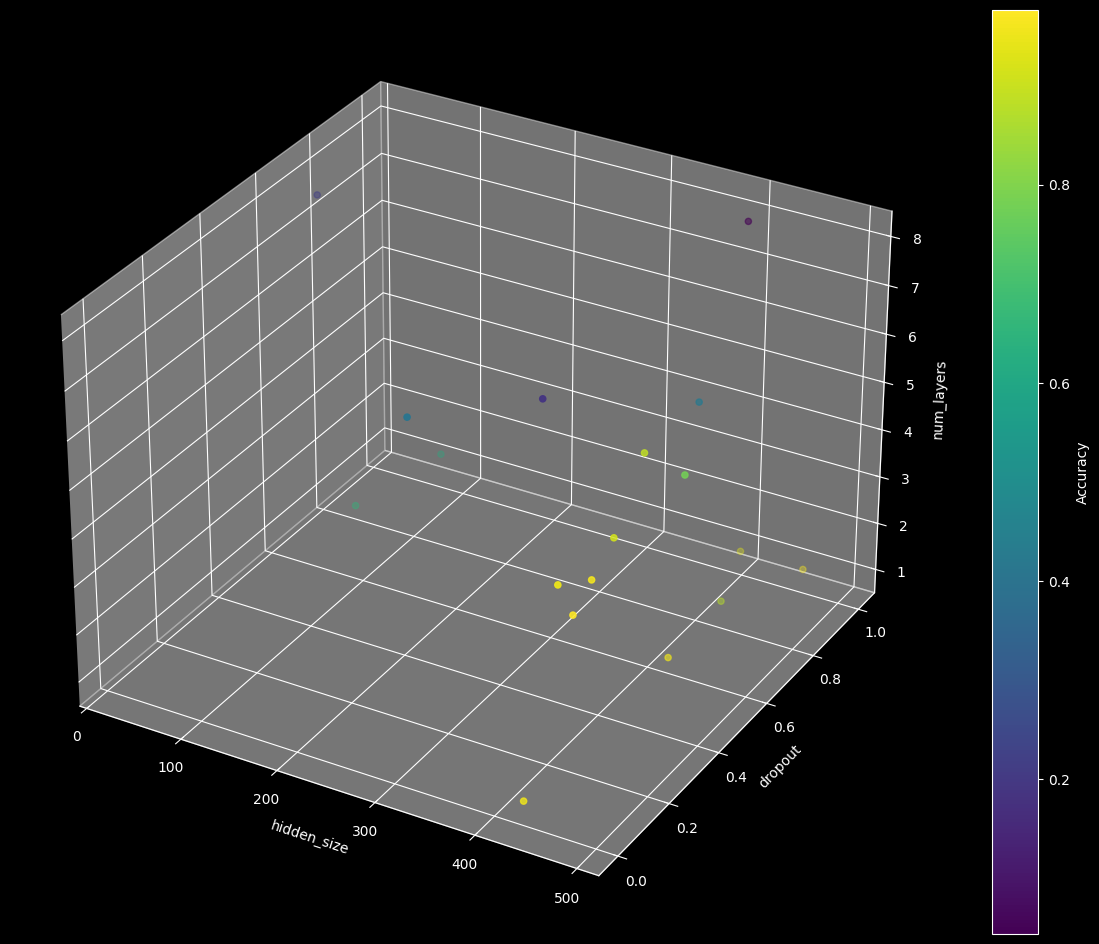

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color representing accuracy
sc = ax.scatter(bayes["config/hidden_size"], bayes["config/dropout"], bayes["config/num_layers"], 
                c=bayes["accuracy"], cmap="viridis")

# Labels
ax.set_xlabel("hidden_size")
ax.set_ylabel("dropout")
ax.set_zlabel("num_layers")
fig.colorbar(sc, label="Accuracy")

plt.show()

<font color='green'>

##### **Explaination**

Similar to the contour-plot, this parallel coordinates plot visualizes the relationship between different hyperparameters and model accuracy. 

- The first axis represents the hidden layer size, ranging from around 16 to 512.
- The second axis shows the dropout rate, which varies between 0 and 1. 
- The third axis shows number of layers of the GRU model, whaich varies from 1 to 8.
- The colorbar indicates model accuracy, where higher values correspond to better performance. 

Each line represents an experiment with a unique combination of these parameters, and the color of the lines reflects accuracy, with darker shades indicating lower accuracy and lighter shades representing higher accuracy. 

**From this plot, we can observe that larger hidden sizes tend to be associated with higher accuracy, while higher dropout values generally lead to lower accuracy. This suggests that while dropout is useful for regularization, too much of it may negatively impact performance because it stops neurons to learn any meaningful weights. By analyzing this visualization, we can identify the best-performing configurations and fine-tune hyperparameters accordingly to optimize model accuracy.**

</font>


In [18]:
from ray.tune.search.bayesopt import BayesOptSearch

bayesopt = BayesOptSearch(random_search_steps=5)

# Defining config for the RESNET model
config = {
    "output_size": 5,
    "dropout": tune.uniform(0, 1.0),
    "fc_layer": tune.uniform(16, 1024),
    "model_name": "RESNET",
    "epochs": MAX_EPOCHS,
    "tune_dir": tune_dir,
}

tic = time.time()

analysis_conv = tune.run(
    tune_model,
    config=config,
    metric="valid_loss",
    mode="min",
    storage_path=str(tune_dir),
    num_samples=N_EXPERIMENTS,
    stop={"training_iteration": MAX_EPOCHS},
    search_alg=bayesopt,
    verbose=1,
    max_concurrent_trials=1,    # To reduce the OEM error
)

time_resnet = time.time() - tic

2025-02-18 18:02:20,887	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/sarmad/Documents/code/upperkaam/notebooks_review/Deliverable_Part_1/notebooks/4_tuning_networks/models/ray/tune_model_2025-02-18_13-55-15' in 0.0042s.
2025-02-18 18:02:20,892	INFO tune.py:1041 -- Total run time: 14825.55 seconds (14825.50 seconds for the tuning loop).


In [19]:
best_conv = analysis_conv.get_best_config()
best_conv["accuracy"] = analysis_conv.best_result["accuracy"]

In [20]:
conv_df = analysis_conv.results_df

In [24]:
columns = ["config/fc_layer", "config/dropout", "accuracy"]
visualize.parallel_plot(analysis_conv, columns)

<font color='green'>

Similar to previous parallel coordinates plot for GRU model visualizes how different configurations of the fully connected (FC) layer size and dropout rate affect the accuracy of a ResNet model with only the last two layers modified. The color gradient represents accuracy, where lighter shades indicate higher accuracy and darker shades indicate lower accuracy.

- The color of each line shows the model's accuracy, where warmer colors (yellow, orange) indicate better accuracy and cooler colors (blue, purple) indicate worse accuracy.
- Some configurations (higher FC layer sizes with moderate dropout) seem to have achieved better accuracy, while some high dropout values negatively impacted accuracy.

**Take aways:**
- Larger FC layers generally help in achieving higher accuracy, but only to a certain extent.
- Very high dropout rates tend to degrade performance, as they remove too many neurons, making learning difficult.
- Moderate dropout values with a reasonably large FC layer seem to perform the best.

</font>